In [1]:
is_colab = 'google.colab' in str(get_ipython())
if is_colab:
    !pip install neuron
    !git clone https://github.com/davidfague/Neural-Modeling.git -b cleanup
    %cd Neural-Modeling/scripts
    !pip install neuron_reduce
    !pip install ipympl

In [2]:
import sys
sys.path.append("../")
sys.path.append("../Modules/")

from Modules.simulation import Simulation
from Modules.cell_builder import SkeletonCell, CellBuilder
from Modules.constants import HayParameters

import os
from neuron import h

from logger import Logger # type: ignore

import numpy as np

--No graphics will be displayed.


In [3]:
sim = Simulation(SkeletonCell.Hay)
parameters = HayParameters(sim_name = 'test', h_tstop= 5000, all_synapses_off=True) # NOTE: synapses will crash the simulation since they are not mapped and will remain on deleted sections

In [5]:
try:
    os.system("rm -r x86_64/")
except:
    pass

rm: cannot remove 'x86_64/': No such file or directory


In [6]:
%cd ../scripts

/home/drfrbc/Neural-Modeling/scripts


/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
os.system(f"nrnivmodl {sim.cell_type.value['modfiles']} > /dev/null 2>&1")

h.load_file('stdrun.hoc')
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')

1.0

In [8]:
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, fixed, FloatSlider

# Setup a global reference for figure and axes
fig, ax = None, None

def plot_segments(seg_data, elevation=0, azimuth=-100, radius_scale=1.0, deleted_indices=[]):
    global fig, ax
    if fig is None or ax is None:
        plt.close('all')  # Close any existing plots
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax.cla()  # Clear the existing axes

    for i, seg in enumerate(seg_data):
        x_points = [seg.coords['p0_0'].iloc[0], seg.coords['pc_0'].iloc[0], seg.coords['p1_0'].iloc[0]]
        y_points = [seg.coords['p0_1'].iloc[0], seg.coords['pc_1'].iloc[0], seg.coords['p1_1'].iloc[0]]
        z_points = [seg.coords['p0_2'].iloc[0], seg.coords['pc_2'].iloc[0], seg.coords['p1_2'].iloc[0]]

        radius = seg.coords['r'].iloc[0] * radius_scale
        color = 'red' if i in deleted_indices else 'black'
        radius = radius*0.1 if i in deleted_indices else radius # can adjust multiplier to increase red radius
        ax.plot(x_points, z_points, y_points, linewidth=radius, color=color)

    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

In [9]:
from Modules.morph_reduction_utils import get_reduced_cell

In [10]:
# from Modules.cell_model import find_nexus_seg
# from Modules.adjacency import get_divergent_children_of_branching_segments

# def get_reduced_cell(cell_builder: CellBuilder, reduce_tufts = False, reduce_basals = False, reduce_obliques = False):
#     cell, _ = cell_builder.build_cell()
    
#     adjacency_matrix = cell.compute_directed_adjacency_matrix()
#     all_segments, original_seg_data = cell.get_segments(['all'])
#     nexus_seg_index = find_nexus_seg(cell, adjacency_matrix)
    
#     all_deleted_seg_indices = []
#     new_sections = []
    
#     root_sections_to_reduce = []
    
#     if reduce_tufts:
#         tuft_root_sections = get_tuft_root_sections(all_segments, nexus_seg_index)
#         root_sections_to_reduce += tuft_root_sections
    
#     if reduce_basals:
#         basal_root_sections = get_basal_root_sections(cell)
#         root_sections_to_reduce += basal_root_sections
    
#     if reduce_obliques:
#         oblique_root_sections = get_oblique_root_sections(adjacency_matrix, all_segments, cell, nexus_seg_index)
#         root_sections_to_reduce += oblique_root_sections
    
#     # import pdb; pdb.set_trace()
    
#     for i,root_section in enumerate(root_sections_to_reduce):
#         try:
#             deleted_seg_indices, new_section = reduce_tree(cell, root_section, all_segments, original_seg_data, adjacency_matrix)
#         except Exception as e:
#             error_msg = f"Failed to reduce tree for section '{i} {str(root_section)}'. Error: {str(e)}"
#             # # Optionally, include additional details:
#             # error_details = {
#             #     "root_section": root_section.name(),
#             #     "num_all_segments": len(all_segments),
#             #     "adjacency_matrix_shape": str(adjacency_matrix.shape) if hasattr(adjacency_matrix, 'shape') else "N/A",
#             #     "original_seg_data_length": len(original_seg_data)
#             # }
#             # # If it's safe to print or log this information:
#             # print("Error Details:", error_details)
#             # Re-raise with additional information
#             raise Exception(error_msg) from e
#         all_deleted_seg_indices.extend(deleted_seg_indices)
#         new_sections.append(new_section)
    
#     new_segments = [seg for new_section in new_sections for seg in list(new_section)]
#     all_segments_after_reduction, new_seg_data = cell.get_segments(['all'])
    
#     return cell, original_seg_data, all_deleted_seg_indices
    
    
# def get_tuft_root_sections(all_segments, nexus_seg_index):
#     nexus_seg = all_segments[nexus_seg_index]
#     return nexus_seg.sec.children()

# def get_basal_root_sections(cell):
#     soma_basal_children = [sec for sec in cell.soma[0].children() if sec in cell.dend]
#     return soma_basal_children

# def get_oblique_root_sections(adjacency_matrix, all_segments, cell, nexus_seg_index):
#     apic_trunk_root_seg_index = all_segments.index(all_segments[0].sec.children()[1](0.0001))
#     oblique_root_seg_indices = get_divergent_children_of_branching_segments(adjacency_matrix, start=apic_trunk_root_seg_index, end=nexus_seg_index)
#     oblique_root_sections = [all_segments[seg_index].sec for seg_index in oblique_root_seg_indices]
    
#     oblique_roots_with_children = [sec for sec in oblique_root_sections if len(sec.children()) > 0]
#     oblique_roots_with_children_seg_indices = [all_segments.index(seg) for sec in oblique_roots_with_children for seg in sec]
    
#     return oblique_roots_with_children

In [11]:
os.mkdir(sim.path)
parameters.path = os.path.join(sim.path, parameters.sim_name)

In [12]:
os.mkdir(parameters.path)

In [13]:
logger = Logger(None)
cell_builder = CellBuilder(sim.cell_type, parameters, logger)

In [20]:
complex_cell, _ = cell_builder.build_cell()
reduced_cell_tufts, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = True, reduce_obliques = False)
reduced_cell_obliques, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = False, reduce_obliques = True)
reduced_cell_basals, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_basals = True)
# reduced_cell_tufts_basals, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = True, reduce_basals = True, reduce_obliques = False)
reduced_cell_tufts_basals_obliques, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = True, reduce_basals = True, reduce_obliques = True)
# reduced_cell_tufts_obliques, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = True, reduce_basals = False, reduce_obliques = True)
# reduced_cell_basals_obliques, original_seg_data, all_deleted_seg_indices = get_reduced_cell(cell_builder, reduce_tufts = False, reduce_basals = True, reduce_obliques = True)

cells = {
    'Complex':complex_cell,
    'Reduced Tufts':reduced_cell_tufts,
    'Reduced Basals':reduced_cell_basals,
    'Reduced Obliques':reduced_cell_obliques,
    # 'Reduced Tufts and Basals':reduced_cell_tufts_basals,
    # 'Reduced Tufts and Obliques':reduced_cell_tufts_obliques,
    # 'Reduced Basals and Obliques':reduced_cell_basals_obliques,
    'Reduced Tufts, Basals, Obliques': reduced_cell_tufts_basals_obliques
}

(2024-05-20 15:14:39.282097)-[PID: 2744304]–[INFO]: Building SkeletonCell.Hay.
all: [L5PCtemplate[0].soma[0], L5PCtemplate[0].dend[0], L5PCtemplate[0].dend[1], L5PCtemplate[0].dend[2], L5PCtemplate[0].dend[3], L5PCtemplate[0].dend[4], L5PCtemplate[0].dend[5], L5PCtemplate[0].dend[6], L5PCtemplate[0].dend[7], L5PCtemplate[0].dend[8], L5PCtemplate[0].dend[9], L5PCtemplate[0].dend[10], L5PCtemplate[0].dend[11], L5PCtemplate[0].dend[12], L5PCtemplate[0].dend[13], L5PCtemplate[0].dend[14], L5PCtemplate[0].dend[15], L5PCtemplate[0].dend[16], L5PCtemplate[0].dend[17], L5PCtemplate[0].dend[18], L5PCtemplate[0].dend[19], L5PCtemplate[0].dend[20], L5PCtemplate[0].dend[21], L5PCtemplate[0].dend[22], L5PCtemplate[0].dend[23], L5PCtemplate[0].dend[24], L5PCtemplate[0].dend[25], L5PCtemplate[0].dend[26], L5PCtemplate[0].dend[27], L5PCtemplate[0].dend[28], L5PCtemplate[0].dend[29], L5PCtemplate[0].dend[30], L5PCtemplate[0].dend[31], L5PCtemplate[0].dend[32], L5PCtemplate[0].dend[33], L5PCtemplate[0].

There is no segment to segment copy, it means that some segments in thereduced model did not receive channels from the original cell.Trying to compensate by copying channels from neighboring segments


Reducing L5PCtemplate[3].dend[78] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=40.792362878131556, diam=0.9095774132494253, space_const=697.8006951062022, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.058458472690290364)
New.dend[80]
Reducing L5PCtemplate[3].dend[63] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=418.26836328992874, diam=1.4028420341307892, space_const=866.5945416639493, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.4826575095739827)
New.dend[80]
Reducing L5PCtemplate[3].dend[42] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=364.9402987036269, diam=1.9481652732119843, space_const=1021.2321129332319, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.3573529407094611)
New.dend[66]
Reducing L5PCtemplate[3].dend[39] and its descendants

There is no segment to segment copy, it means that some segments in thereduced model did not receive channels from the original cell.Trying to compensate by copying channels from neighboring segments


Reducing L5PCtemplate[4].dend[78] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=40.792362878131556, diam=0.9095774132494253, space_const=697.8006951062022, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.058458472690290364)
New.dend[80]
Reducing L5PCtemplate[4].dend[63] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=418.26836328992874, diam=1.4028420341307892, space_const=866.5945416639493, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.4826575095739827)
New.dend[80]
Reducing L5PCtemplate[4].dend[42] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=364.9402987036269, diam=1.9481652732119843, space_const=1021.2321129332319, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.3573529407094611)
New.dend[66]
Reducing L5PCtemplate[4].dend[39] and its descendants

There is no segment to segment copy, it means that some segments in thereduced model did not receive channels from the original cell.Trying to compensate by copying channels from neighboring segments


Reducing L5PCtemplate[5].dend[78] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=40.792362878131556, diam=0.9095774132494253, space_const=697.8006951062022, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.058458472690290364)
New.dend[80]
Reducing L5PCtemplate[5].dend[63] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=418.26836328992874, diam=1.4028420341307892, space_const=866.5945416639493, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.4826575095739827)
New.dend[80]
Reducing L5PCtemplate[5].dend[42] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=364.9402987036269, diam=1.9481652732119843, space_const=1021.2321129332319, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.3573529407094611)
New.dend[66]
Reducing L5PCtemplate[5].dend[39] and its descendants

There is no segment to segment copy, it means that some segments in thereduced model did not receive channels from the original cell.Trying to compensate by copying channels from neighboring segments


Reducing L5PCtemplate[7].dend[78] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=40.792362878131556, diam=0.9095774132494253, space_const=697.8006951062022, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.058458472690290364)
New.dend[80]
Reducing L5PCtemplate[7].dend[63] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=418.26836328992874, diam=1.4028420341307892, space_const=866.5945416639493, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.4826575095739827)
New.dend[80]
Reducing L5PCtemplate[7].dend[42] and its descendants to single uniform cylindrical cable.
new_cable_properties: CableParams(length=364.9402987036269, diam=1.9481652732119843, space_const=1021.2321129332319, cm=2.0, rm=21413.276231263386, ra=100.0, e_pas=-90.0, electrotonic_length=0.3573529407094611)
New.dend[66]
Reducing L5PCtemplate[7].dend[39] and its descendants

In [21]:
# define custom synpase distribution ( in this case 700 exc 300 inh)
from Modules.spike_generator import PoissonTrainGenerator
from Modules.presynaptic import PCBuilder
from functools import partial
import scipy.stats as st

def build_synapses(cell, random_state):
    # craete synapse objects
    #self.logger.log("Building excitatory synapses.")
    build_excitatory_synapses(cell = cell)

    #self.logger.log("Building inhibitory synapses.")
    build_inhibitory_synapses(cell = cell)

    #self.logger.log("Building soma synapses.")
    build_soma_synapses(cell = cell)

    # Assign spike trains
    #self.logger.log("Assigning excitatory spike trains.")
    assign_exitatory_spike_trains(cell = cell, random_state = random_state)

    #self.logger.log("Assigning inhibitory spike trains.")
    assign_inhibitory_spike_trains(cell = cell, random_state = random_state)

    #self.logger.log("Assigning soma spike trains.")
    assign_soma_spike_trains(cell = cell, random_state = random_state)

def binned_log_norm_dist(gmax_mean, gmax_std, gmax_scalar, size, clip):
	val = np.random.lognormal(gmax_mean, gmax_std, size)
	s = gmax_scalar * float(np.clip(val, clip[0], clip[1]))

	# Bin
	num_bins = 10
	bin_size = (clip[1] - clip[0]) / num_bins
	bins = np.arange(0, clip[1], bin_size)
	ind = np.digitize(s, bins)

	if ind == num_bins:
		return bins[-1]
	else:
		return bins[ind]

def assign_soma_spike_trains(cell, random_state) -> None:

    PCBuilder.assign_presynaptic_cells(
        cell = cell,
        n_func_gr = 1,
        n_pc_per_fg = 1,
        synapse_names = ["soma"]
    )

    # Proximal inh mean_fr distribution
    mean_fr, std_fr = parameters.inh_prox_mean_fr, parameters.inh_prox_std_fr
    a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
    proximal_inh_dist = partial(st.truncnorm.rvs, a = a, b = b, loc = mean_fr, scale = std_fr)

    for i, synapse in enumerate(cell.synapses):
        if synapse.name == "soma":
            mean_fr = proximal_inh_dist(size = 1)
            firing_rates = PoissonTrainGenerator.generate_lambdas_from_pink_noise(
                num = parameters.h_tstop,
                random_state = random_state,
                lambda_mean = mean_fr)
            spike_train = PoissonTrainGenerator.generate_spike_train(
                lambdas = firing_rates, 
                random_state = random_state)

            cell.synapses[i].set_spike_train_for_pc(mean_fr = mean_fr, spike_train = spike_train.spike_times)


def assign_inhibitory_spike_trains(cell, random_state) -> None:

    PCBuilder.assign_presynaptic_cells(
        cell = cell,
        n_func_gr = parameters.inh_distributed_n_FuncGroups,
        n_pc_per_fg = parameters.inh_distributed_n_PreCells_per_FuncGroup,
        synapse_names = ["inh"]
    )

    # Proximal inh mean_fr distribution
    mean_fr, std_fr = parameters.inh_prox_mean_fr, parameters.inh_prox_std_fr
    a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
    proximal_inh_dist = partial(st.truncnorm.rvs, a = a, b = b, loc = mean_fr, scale = std_fr)

    # Distal inh mean_fr distribution
    mean_fr, std_fr = parameters.inh_distal_mean_fr, parameters.inh_distal_std_fr
    a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
    distal_inh_dist = partial(st.truncnorm.rvs, a = a, b = b, loc = mean_fr, scale = std_fr)

    soma_coords = cell.get_segments(["soma"])[1][0].coords[["pc_0", "pc_1", "pc_2"]].to_numpy()

    for i, synapse in enumerate(cell.synapses):
        if synapse.name == "inh":
            if np.linalg.norm(soma_coords - synapse.pc.cluster_center) < 100:
                mean_fr = proximal_inh_dist(size = 1)
            else:
                mean_fr = distal_inh_dist(size = 1)

            firing_rates = PoissonTrainGenerator.generate_lambdas_from_pink_noise(
                num = parameters.h_tstop,
                random_state = random_state,
                lambda_mean = mean_fr)
            spike_train = PoissonTrainGenerator.generate_spike_train(
                lambdas = firing_rates, 
                random_state = random_state)
            
            cell.synapses[i].set_spike_train_for_pc(mean_fr = mean_fr, spike_train = spike_train.spike_times)


def assign_exitatory_spike_trains(cell, random_state) -> None:

    PCBuilder.assign_presynaptic_cells(
        cell = cell,
        n_func_gr = parameters.exc_n_FuncGroups,
        n_pc_per_fg = parameters.exc_n_PreCells_per_FuncGroup,
        synapse_names = ["exc"]
    )

    # Distribution of mean firing rates
    # mean_fr_dist = partial(gamma_dist, mean = self.parameters.exc_mean_fr, size = 1)
    mean_fr, std_fr = parameters.exc_mean_fr, parameters.exc_std_fr
    a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
    mean_fr_dist = partial(st.truncnorm.rvs, a = a, b = b, loc = mean_fr, scale = std_fr)

    for i, synapse in enumerate(cell.synapses):
        if synapse.name == "exc":
            mean_fr = mean_fr_dist(size = 1)
            firing_rates = PoissonTrainGenerator.generate_lambdas_from_pink_noise(
                num = parameters.h_tstop,
                random_state = random_state,
                lambda_mean = mean_fr)
            spike_train = PoissonTrainGenerator.generate_spike_train(
                lambdas = firing_rates, 
                random_state = random_state)
            cell.synapses[i].set_spike_train_for_pc(mean_fr = mean_fr, spike_train = spike_train.spike_times)

            
def build_soma_synapses(cell) -> None:
    
    if (parameters.CI_on) or (not parameters.add_soma_inh_synapses):
        return None
    
    # inh_soma_P_dist = partial(
    # 	P_release_dist, 
    # 	P_mean = self.parameters.inh_soma_P_release_mean, 
    # 	P_std = self.parameters.inh_soma_P_release_std, 
    # 	size = 1)
    
    segments, seg_data = cell.get_segments(["soma"])
    probs = [data.membrane_surface_area for data in seg_data]
    
    cell.add_synapses_over_segments(
        segments = segments,
        nsyn = 100,
        syn_mod = parameters.inh_syn_mod,
        syn_params = parameters.inh_syn_params,
        gmax = parameters.soma_gmax_dist,
        name = "soma",
        density = False,
        seg_probs = probs,
        release_p = None)
        
def build_inhibitory_synapses(cell) -> None:
    
    if parameters.CI_on:
        return None
    
    # Inhibitory release probability distributions
    # inh_apic_P_dist = partial(
    # 	P_release_dist, 
    # 	P_mean = self.parameters.inh_apic_P_release_mean, 
    # 	P_std = self.parameters.inh_apic_P_release_std, 
    # 	size = 1)
    # inh_basal_P_dist = partial(
    # 	P_release_dist, 
    # 	P_mean = self.parameters.inh_basal_P_release_mean, 
    # 	P_std = self.parameters.inh_basal_P_release_std, 
    # 	size = 1)
    
    # inh_P_dist = {}
    # inh_P_dist["apic"] = inh_apic_P_dist
    # inh_P_dist["dend"] = inh_basal_P_dist
    
    segments, seg_data = cell.get_segments(["apic", "dend"])
    probs = [data.membrane_surface_area for data in seg_data]

    cell.add_synapses_over_segments(
        segments = segments,
        nsyn = 200,
        syn_mod = parameters.inh_syn_mod,
        syn_params = parameters.inh_syn_params,
        gmax = parameters.inh_gmax_dist,
        name = "inh",
        density = False,
        seg_probs = probs,
        release_p = None)
        
def build_excitatory_synapses(cell) -> None:
    
    if parameters.CI_on:
        return None

    # Excitatory gmax distribution
    gmax_exc_dist = partial(
        binned_log_norm_dist,#log_norm_dist, 
        parameters.exc_gmax_mean_0, 
        parameters.exc_gmax_std_0, 
        parameters.exc_scalar, 
        size = 1, 
        clip = parameters.exc_gmax_clip)
    
    # exc release probability distribution everywhere
    # exc_P_dist = partial(
    # 	P_release_dist, 
    # 	P_mean = self.parameters.exc_P_release_mean, 
    # 	P_std = self.parameters.exc_P_release_std, 
    # 	size = 1)

    segments, seg_data = cell.get_segments(["apic", "dend"])
    if parameters.use_SA_exc:
        probs = [data.membrane_surface_area for data in seg_data]
    else:
        raise NotImplementedError

    cell.add_synapses_over_segments(
        segments = segments,
        nsyn = 700,
        syn_mod = parameters.exc_syn_mod,
        syn_params = parameters.exc_syn_params,
        gmax = gmax_exc_dist,
        name = "exc",
        density = False,
        seg_probs = probs,
        release_p = None)

In [22]:
# build synapses (2 cases)

for cell_name, cell in cells.items():
    random_state = np.random.RandomState(parameters.numpy_random_state)
    cell_builder.build_synapses(cell, random_state) # with synaptic densities as defined by constants.py & original script/code
    # build_synapses(cell, random_state) # with 1000 synapses as defined by the functions in this notebook.

(2024-05-20 15:15:58.925703)-[PID: 2744304]–[INFO]: Building excitatory synapses.
(2024-05-20 15:16:34.435911)-[PID: 2744304]–[INFO]: Building inhibitory synapses.
(2024-05-20 15:16:38.514403)-[PID: 2744304]–[INFO]: Building soma synapses.
(2024-05-20 15:16:38.524016)-[PID: 2744304]–[INFO]: Assigning excitatory spike trains.
(2024-05-20 15:19:11.611837)-[PID: 2744304]–[INFO]: Assigning inhibitory spike trains.
(2024-05-20 15:19:44.359318)-[PID: 2744304]–[INFO]: Assigning soma spike trains.
(2024-05-20 15:19:46.636078)-[PID: 2744304]–[INFO]: Building excitatory synapses.
(2024-05-20 15:20:10.458180)-[PID: 2744304]–[INFO]: Building inhibitory synapses.
(2024-05-20 15:20:13.190003)-[PID: 2744304]–[INFO]: Building soma synapses.
(2024-05-20 15:20:13.200468)-[PID: 2744304]–[INFO]: Assigning excitatory spike trains.
(2024-05-20 15:22:18.886540)-[PID: 2744304]–[INFO]: Assigning inhibitory spike trains.
(2024-05-20 15:22:44.709240)-[PID: 2744304]–[INFO]: Assigning soma spike trains.
(2024-05-2

Show Reduced Cell

In [23]:
parameters.record_ecp = True

In [24]:
import Modules.analysis as analysis

In [25]:
# !python3 plot_lfp.py -d SkeletonCell.Hay-07-05-2024-17-20-41/test

Some Notes: 
Compare detailed and reduced
Try allen database cell
1. We adapted neuron_reduce for more user-control.
2. Currently not Mapping synapses, but it will be easy to add.
3. We could convert single-cylinders into an equivalent set of nbranches.

COMPARISONS

In [26]:
for cell_name, cell in cells.items():
    sim.set_all_recorders(cell, parameters)

(2024-05-20 15:36:35.317734)-[PID: 2744304]–[WARNING]: Recording ECP adds the extracellular channel to all segments after computing electrotonic distance.                                      This channel is therefore not accounted for in impedence calculation, but it might affect the simulation.
(2024-05-20 15:36:36.290025)-[PID: 2744304]–[WARNING]: Recording ECP adds the extracellular channel to all segments after computing electrotonic distance.                                      This channel is therefore not accounted for in impedence calculation, but it might affect the simulation.
(2024-05-20 15:36:37.080159)-[PID: 2744304]–[WARNING]: Recording ECP adds the extracellular channel to all segments after computing electrotonic distance.                                      This channel is therefore not accounted for in impedence calculation, but it might affect the simulation.
(2024-05-20 15:36:37.924418)-[PID: 2744304]–[WARNING]: Recording ECP adds the extracellular channel to all

simulating Complex
(2024-05-20 15:36:40.421145)-[PID: 2744304]–[INFO]: Starting simulation.
(2024-05-20 15:46:39.137576)-[PID: 2744304]–[INFO]: Saving data at step: 10000
(2024-05-20 15:46:39.235108)-[PID: 2744304]–[INFO]: Finished writing data
(2024-05-20 15:46:39.236201)-[PID: 2744304]–[INFO]: Finished clearing recorders
(2024-05-20 15:54:36.449716)-[PID: 2744304]–[INFO]: Saving data at step: 20000
(2024-05-20 15:54:36.524469)-[PID: 2744304]–[INFO]: Finished writing data
(2024-05-20 15:54:36.525523)-[PID: 2744304]–[INFO]: Finished clearing recorders
(2024-05-20 16:02:26.091728)-[PID: 2744304]–[INFO]: Saving data at step: 30000
(2024-05-20 16:02:26.163074)-[PID: 2744304]–[INFO]: Finished writing data
(2024-05-20 16:02:26.164083)-[PID: 2744304]–[INFO]: Finished clearing recorders
(2024-05-20 16:10:15.192817)-[PID: 2744304]–[INFO]: Saving data at step: 40000
(2024-05-20 16:10:15.268174)-[PID: 2744304]–[INFO]: Finished writing data
(2024-05-20 16:10:15.269176)-[PID: 2744304]–[INFO]: Fini

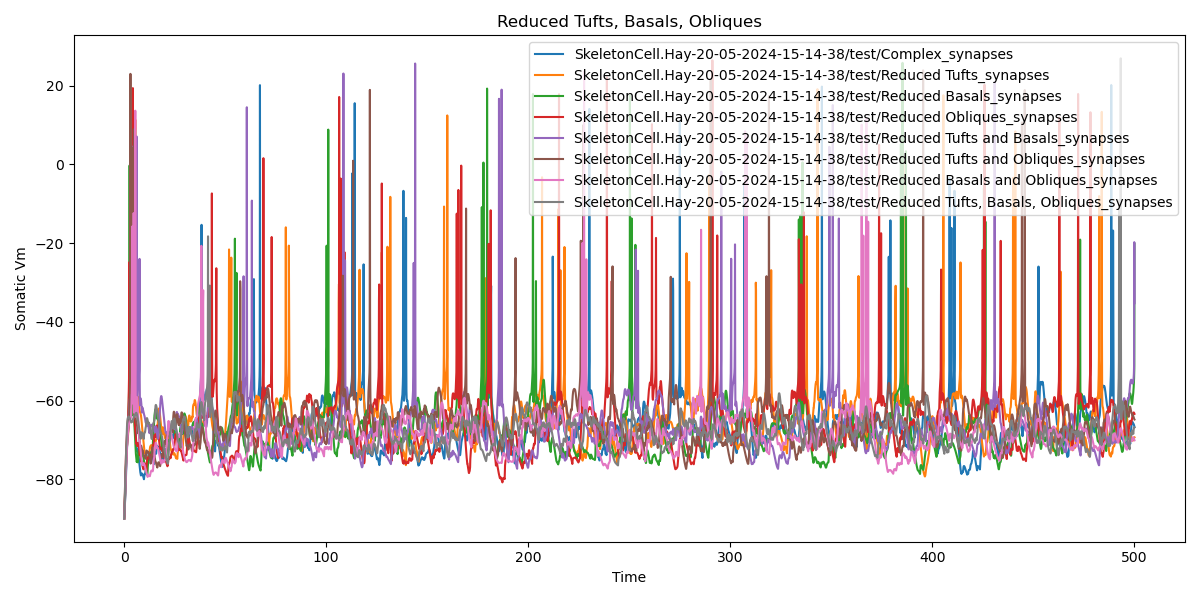

Correlation between Complex Cell and Reduced Tufts: 0.010409676624650054
Correlation between Complex Cell and Reduced Basals: -0.005846941872791084
Correlation between Complex Cell and Reduced Obliques: 0.1204482939205711
Correlation between Complex Cell and Reduced Tufts and Basals: 0.053851311170236005
Correlation between Complex Cell and Reduced Tufts and Obliques: 0.09108888922607576
Correlation between Complex Cell and Reduced Basals and Obliques: 0.1621811151816518
Correlation between Complex Cell and Reduced Tufts, Basals, Obliques: 0.11469998899955246


In [27]:
import shutil
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.stats import pearsonr

# Adjust the parameters and initialize the cell structure here
root_path = parameters.path
FI_paths = []
parameters.h_tstop = 5000
parameters.h_i_duration = 1950
parameters.h_i_delay = 50
# amps = np.arange(-2, 2.1, 0.2)

# Prepare subplots: one for the somatic injection, another for the nexus injection
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

# Create a CSV file to store the results
csv_file_path = "FI_Curve_Data.csv"
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Cell Name", "Firing Rate (Hz)"])

    # Dictionary to store data for each cell
    cell_data = {}

    for ax in [axes]:
        for cell_name, cell in cells.items():
            firing_rates = []

            parameters.path = root_path + f"/{cell_name}_synapses"
            # os.mkdir(parameters.path)
            # with open(os.path.join(parameters.path, "parameters.pickle"), "wb") as file:
            #     pickle.dump(parameters, file)
            FI_paths.append(parameters.path)

            # Perform simulation
            print(f"simulating {cell_name}")
            sim.simulate(cell, parameters)

            # Read the voltage and spike data
            v = analysis.DataReader.read_data(parameters.path, "v", parameters=parameters)
            soma_spikes = analysis.DataReader.read_data(parameters.path, "soma_spikes", parameters=parameters)

            # Calculate the firing rate
            firing_rate = len(soma_spikes[0]) / (parameters.h_tstop / 1000)
            firing_rates.append(firing_rate)

            # Write the results to the CSV file
            writer.writerow([cell_name, firing_rate])

            # Store the data for later analysis
            cell_data[cell_name] = v[0]

            label = cell_name
            ax.plot(np.arange(0, len(v[0])) * parameters.h_dt, v[0], label=parameters.path)

        ax.set_title(cell_name)
        ax.set_xlabel('Time')
        ax.set_ylabel('Somatic Vm')
        # ax.set_xlim(0,2)
        ax.legend()

# Display the plots
plt.tight_layout()

# Save the figure to the current directory
plt.savefig("Synapses_Vm_no_mapping.png")  # You can specify other formats like 'pdf' by changing the file extension

plt.show()

# Clean up temporary directories
for FI_path in FI_paths:
    shutil.rmtree(FI_path)

# Compute correlations with the "Complex Cell" data
complex_cell_data = cell_data.get("Complex")
correlations = {}
if complex_cell_data is not None:
    for cell_name, data in cell_data.items():
        if cell_name != "Complex":
            correlation, _ = pearsonr(complex_cell_data, data)
            correlations[cell_name] = correlation

# Print correlations
for cell_name, correlation in correlations.items():
    print(f"Correlation between Complex Cell and {cell_name}: {correlation}")

# Optionally, store the data and correlations in a file
with open("Cell_Data_and_Correlations.pkl", "wb") as file:
    pickle.dump({"cell_data": cell_data, "correlations": correlations}, file)


In [28]:
cell_data.get('Complex')

array([-90.        , -89.14811701, -88.157826  , ..., -66.26611892,
       -66.46680465, -66.69535782])

In [29]:
# Print correlations
for cell_name, correlation in correlations.items():
    print(f"Correlation between Complex Cell and {cell_name}: {correlation}")

Correlation between Complex Cell and Reduced Tufts: 0.010409676624650054
Correlation between Complex Cell and Reduced Basals: -0.005846941872791084
Correlation between Complex Cell and Reduced Obliques: 0.1204482939205711
Correlation between Complex Cell and Reduced Tufts and Basals: 0.053851311170236005
Correlation between Complex Cell and Reduced Tufts and Obliques: 0.09108888922607576
Correlation between Complex Cell and Reduced Basals and Obliques: 0.1621811151816518
Correlation between Complex Cell and Reduced Tufts, Basals, Obliques: 0.11469998899955246
